In [1]:
import pandas as pd

# 读取数据
data = pd.read_csv("data/1_dataset_fillna.csv")
data = data.drop(["M", "Anion", "CC"], axis=1)
data

,O,N,B,S,P,SSA,PV,RMIC,Dap,ID/IG,AML,PW,CD,Cs
0,7.15,3.52,0.00,0.0,0.0,1546.1,0.5753,0.939857,1.488390,1.029,1.00,1.6,0.10,85.0
1,8.12,3.79,3.66,0.0,0.0,1315.2,0.5116,0.931392,1.555961,1.038,1.00,1.6,0.10,114.0
2,21.55,3.29,0.00,0.0,0.0,1140.8,0.8600,0.209302,3.015428,0.820,2.50,1.8,0.10,90.2
3,21.55,3.29,0.00,0.0,0.0,1140.8,0.8600,0.209302,3.015428,0.820,2.50,1.8,0.25,86.3
4,21.55,3.29,0.00,0.0,0.0,1140.8,0.8600,0.209302,3.015428,0.820,2.50,1.8,0.50,79.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,4.68,5.02,0.00,0.0,0.0,166.6,0.1380,0.289855,3.313325,0.830,2.75,1.6,10.00,67.1
668,4.68,5.02,0.00,0.0,0.0,166.6,0.1380,0.289855,3.313325,0.830,2.75,1.6,20.00,63.1
669,4.68,5.02,0.00,0.0,0.0,166.6,0.1380,0.289855,3.313325,0.830,2.75,1.6,30.00,59.6
670,4.68,5.02,0.00,0.0,0.0,166.6,0.1380,0.289855,3.313325,0.830,2.75,1.6,40.00,59.3


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 按目标值分布按10个等级进行数据分割
data['target_class'] = pd.qcut(data['Cs'], q=10, labels=False)
X = data.drop('Cs', axis=1)
y = data['Cs']
stratify_column = data['target_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=stratify_column)

# 数据标准化
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 将数据转换成DF以便后续使用
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [4]:
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from xgboost import XGBRegressor

# 定义超参数空间，所有超参数均使用 quniform（离散均匀分布）
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 100, 10),    # 弱学习器的数量，范围从50到500，步长为50
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.3, 0.01),  # 学习率，范围从0.01到0.2，步长为0.01
    'max_depth': hp.quniform('max_depth', 3, 10, 1),             # 树的最大深度，范围从3到10，步长为1
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),  # 最小叶子节点样本权重和，范围从1到10，步长为1
    'gamma': hp.quniform('gamma', 0, 1, 0.05),                 # 最小分裂损失下降，范围从0到0.5，步长为0.05
    'subsample': hp.quniform('subsample', 0.1, 1.0, 0.05),       # 采样比例，范围从0.6到1.0，步长为0.05
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1.0, 0.05),  # 特征采样比例，范围从0.6到1.0，步长为0.05
    'colsample_bylevel': hp.quniform('colsample_bylevel', 0.1, 1.0, 0.05),  # 控制树的每一层构建时，从总特征中随机采样的比例
    'colsample_bynode':hp.quniform('colsample_bynode', 0.1, 1.0, 0.05),   # 控制每个节点分裂时，从总特征中随机采样的比例
    'reg_alpha': hp.quniform('reg_alpha', 0, 0.1, 0.01),         # L1 正则化项，范围从0到0.1，步长为0.01
    'reg_lambda': hp.quniform('reg_lambda', 0.5, 2, 0.1),        # L2 正则化项，范围从0.5到2，步长为0.1
    'scale_pos_weight': hp.quniform('scale_pos_weight', 1, 5, 1),# 正负样本平衡权重，范围从1到5，步长为1
    'max_delta_step': hp.quniform('max_delta_step', 0, 10, 1),   # 最大步长，范围从0到10，步长为1
}

# 定义目标函数
def objective(params):
    # 将参数转换为整数或浮点数
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['max_delta_step'] = int(params['max_delta_step'])
    params['scale_pos_weight'] = int(params['scale_pos_weight'])
    params['learning_rate'] = float(params['learning_rate'])
    params['gamma'] = float(params['gamma'])
    params['subsample'] = float(params['subsample'])
    params['colsample_bytree'] = float(params['colsample_bytree'])
    params['colsample_bylevel'] = float(params['colsample_bylevel'])
    params['colsample_bynode'] = float(params['colsample_bynode'])
    params['reg_alpha'] = float(params['reg_alpha'])
    params['reg_lambda'] = float(params['reg_lambda'])

    # 初始化模型
    model = XGBRegressor(
        objective='reg:squarederror',
        random_state=21,
        **params
    )
    # 使用交叉验证评估模型性能
    scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
    rmse = -scores.mean()
    return {'loss': rmse, 'status': STATUS_OK}

# 进行超参数优化
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=500,  # 最大评估次数，可以根据需要调整
    trials=trials
)

# 输出最佳参数
print("最佳参数：")
for param in best:
    print(f"{param}: {best[param]}")

# 使用最佳参数训练模型
best_params = {
    'n_estimators': int(best['n_estimators']),
    'learning_rate': float(best['learning_rate']),
    'max_depth': int(best['max_depth']),
    'min_child_weight': int(best['min_child_weight']),
    'gamma': float(best['gamma']),
    'subsample': float(best['subsample']),
    'colsample_bytree': float(best['colsample_bytree']),
    'colsample_bylevel': float(best['colsample_bylevel']),
    'colsample_bynode': float(best['colsample_bynode']),
    'reg_alpha': float(best['reg_alpha']),
    'reg_lambda': float(best['reg_lambda']),
    'scale_pos_weight': int(best['scale_pos_weight']),
    'max_delta_step': int(best['max_delta_step'])
}

100%|██████████| 500/500 [05:28<00:00,  1.52trial/s, best loss: 6.926921140299134]
最佳参数：
colsample_bylevel: 0.65
colsample_bynode: 0.9
colsample_bytree: 0.5
gamma: 0.55
learning_rate: 0.18
max_delta_step: 0.0
max_depth: 5.0
min_child_weight: 1.0
n_estimators: 100.0
reg_alpha: 0.04
reg_lambda: 1.3
scale_pos_weight: 1.0
subsample: 1.0


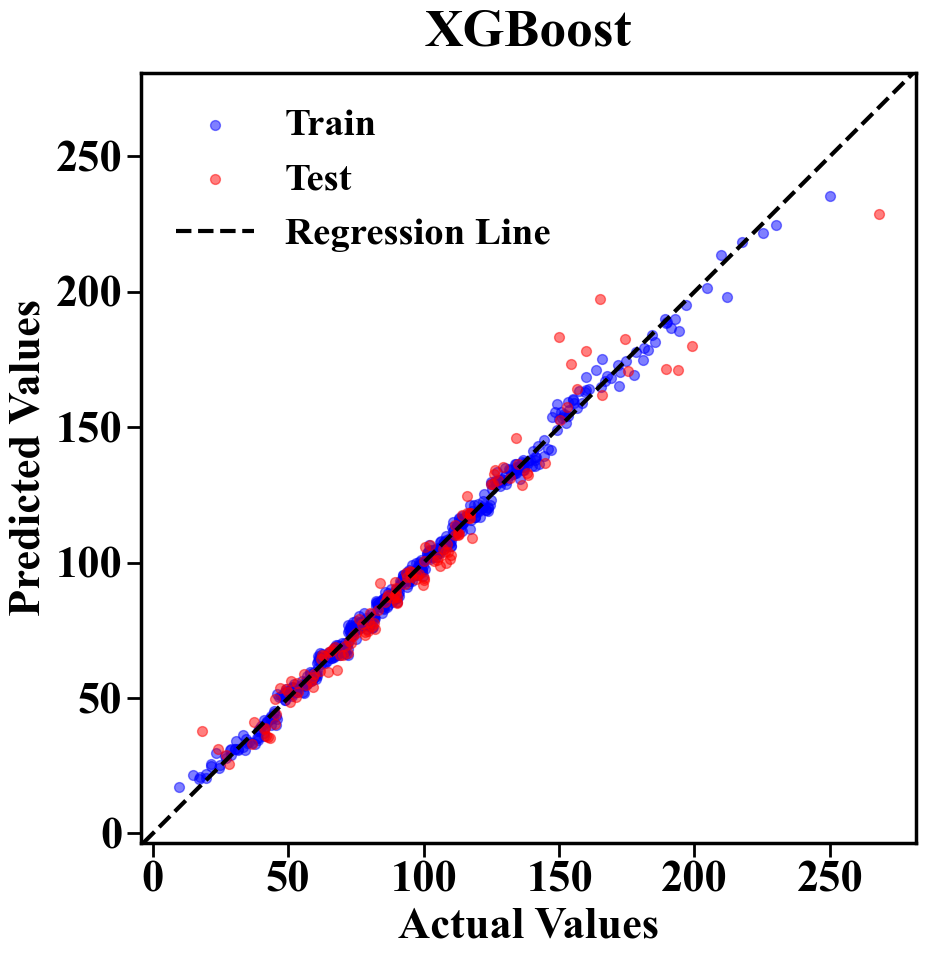

,model,R2_train,MAE_train,MAPE_train,RMSE_train,R2_test,MAE_test,MAPE_test,RMSE_test
0,XGBoost,0.995381,2.009813,2.732389,2.698205,0.961546,4.983446,5.944364,7.867307


In [8]:
from function import metrics_to_dataframe, plot_actual_vs_predicted

# 初始化模型
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=21,
    **best_params
)

xgb.fit(X_train_scaled, y_train)

y_train_pred = xgb.predict(X_train_scaled)
y_test_pred = xgb.predict(X_test_scaled)

xgb_metrics = metrics_to_dataframe(y_train, y_train_pred, y_test, y_test_pred, 'XGBoost')
plot_actual_vs_predicted(y_train, y_train_pred, y_test, y_test_pred, 'XGBoost','output/figures/XGB.png')

xgb_metrics